In [1]:
import warnings
warnings.filterwarnings("ignore")
# Libraries to read and manipulate data
import pandas as pd
import numpy as np

# libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from statsmodels.api import OLS, add_constant

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

#libraries for convenience
from datetime import datetime
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data = pd.read_csv('../Resources/Reg_season_consolidated.csv')
playoffs = pd.read_csv('../Resources/Playoff_games.csv')
# copying data to preserve original
games_data = data.copy()
playoffs.drop(['Unnamed: 0'],axis= 1)
playoffs = playoffs[['HOME_TEAM_NAME','GAME_DATE']]
playoffs

,HOME_TEAM_NAME,GAME_DATE
0,Pistons,2004-06-15
1,Pistons,2004-06-13
2,Pistons,2004-06-10
3,Lakers,2004-06-08
4,Lakers,2004-06-06
...,...,...
1491,Jazz,2021-05-23
1492,Bucks,2021-05-22
1493,Clippers,2021-05-22
1494,Nets,2021-05-22


In [3]:
playoffs['GAME_DATE'] = pd.to_datetime(playoffs['GAME_DATE'],yearfirst=True)
playoffs['GAME_DATE'] = pd.DatetimeIndex(playoffs['GAME_DATE']).year
playoffs

,HOME_TEAM_NAME,GAME_DATE
0,Pistons,2004
1,Pistons,2004
2,Pistons,2004
3,Lakers,2004
4,Lakers,2004
...,...,...
1491,Jazz,2021
1492,Bucks,2021
1493,Clippers,2021
1494,Nets,2021


In [4]:
playoffs['UNIQUE_SEASONS'] = playoffs['HOME_TEAM_NAME'] + '-' + playoffs.GAME_DATE.astype(str)
playoffs

,HOME_TEAM_NAME,GAME_DATE,UNIQUE_SEASONS
0,Pistons,2004,Pistons-2004
1,Pistons,2004,Pistons-2004
2,Pistons,2004,Pistons-2004
3,Lakers,2004,Lakers-2004
4,Lakers,2004,Lakers-2004
...,...,...,...
1491,Jazz,2021,Jazz-2021
1492,Bucks,2021,Bucks-2021
1493,Clippers,2021,Clippers-2021
1494,Nets,2021,Nets-2021


In [5]:
playoffs = playoffs.groupby(['UNIQUE_SEASONS']).sum()
playoffs

,GAME_DATE
UNIQUE_SEASONS,
76ers-2005,4010
76ers-2008,6024
76ers-2009,6027
76ers-2011,4022
76ers-2012,12072
...,...
Wizards-2014,10070
Wizards-2015,10075
Wizards-2017,12102


In [6]:
playoffs['UNIQUE_SEASONS'] = playoffs.index
playoffs.reset_index(inplace=True,drop=True)
playoffs = playoffs.drop(['GAME_DATE'],axis=1)
playoffs

,UNIQUE_SEASONS
0,76ers-2005
1,76ers-2008
2,76ers-2009
3,76ers-2011
4,76ers-2012
...,...
283,Wizards-2014
284,Wizards-2015
285,Wizards-2017
286,Wizards-2018


In [7]:
playoff_list = list(playoffs['UNIQUE_SEASONS'])

In [8]:
games_data = games_data.drop(['Unnamed: 0'],axis=1)
games_data['UNIQUE_SEASONS'] = games_data['TEAM_NAME'] + '-' + games_data.Year.astype(str)
games_data['Made_Playoffs'] = 0
games_data

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year,Attendance,UNIQUE_SEASONS,Made_Playoffs
0,76ers,42.981,32.351,76.104,19.808,41.987,32,2004,788.128,76ers-2004,0
1,76ers,44.952,36.389,78.277,20.970,41.668,45,2005,732.686,76ers-2005,0
2,76ers,45.492,35.458,75.373,19.941,39.214,31,2006,677.278,76ers-2006,0
3,76ers,45.771,33.760,75.141,20.420,41.034,41,2007,608.603,76ers-2007,0
4,76ers,45.942,29.984,71.110,20.481,42.581,39,2008,609.675,76ers-2008,0
...,...,...,...,...,...,...,...,...,...,...,...
535,Wizards,47.182,37.792,77.733,23.923,43.454,54,2017,697.107,Wizards-2017,0
536,Wizards,47.024,35.646,77.447,26.306,41.650,36,2018,718.946,Wizards-2018,0
537,Wizards,46.813,35.832,77.988,26.969,43.190,28,2019,716.996,Wizards-2019,0
538,Wizards,45.339,36.590,76.635,24.077,42.155,15,2020,532.702,Wizards-2020,0


In [9]:
for idx in np.arange(0,len(games_data['UNIQUE_SEASONS']),1):
    if games_data['UNIQUE_SEASONS'][idx] in playoff_list:
        games_data['Made_Playoffs'][idx] = 1
games_data

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year,Attendance,UNIQUE_SEASONS,Made_Playoffs
0,76ers,42.981,32.351,76.104,19.808,41.987,32,2004,788.128,76ers-2004,0
1,76ers,44.952,36.389,78.277,20.970,41.668,45,2005,732.686,76ers-2005,1
2,76ers,45.492,35.458,75.373,19.941,39.214,31,2006,677.278,76ers-2006,0
3,76ers,45.771,33.760,75.141,20.420,41.034,41,2007,608.603,76ers-2007,0
4,76ers,45.942,29.984,71.110,20.481,42.581,39,2008,609.675,76ers-2008,1
...,...,...,...,...,...,...,...,...,...,...,...
535,Wizards,47.182,37.792,77.733,23.923,43.454,54,2017,697.107,Wizards-2017,1
536,Wizards,47.024,35.646,77.447,26.306,41.650,36,2018,718.946,Wizards-2018,1
537,Wizards,46.813,35.832,77.988,26.969,43.190,28,2019,716.996,Wizards-2019,0
538,Wizards,45.339,36.590,76.635,24.077,42.155,15,2020,532.702,Wizards-2020,0


In [10]:
X = games_data.drop(['Year','TEAM_NAME','UNIQUE_SEASONS','Made_Playoffs'],axis=1)
y = games_data['Made_Playoffs']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, stratify=y)
print(X_train.shape, X_test.shape)

(405, 7) (135, 7)


In [12]:
# Use Scaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [13]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
class decisiontree:
    name = "Decision Tree Classifier"
    model = DecisionTreeClassifier(random_state=1)
class bagging:
    name = "Bagging Classifier"
    model = BaggingClassifier(random_state=1)
class logitreg:
    name = "Logistic Regression Classifier"
    model = LogisticRegression(solver='lbfgs', random_state=1)
class randiforestclass:
    name = "Random Forest Classifier"
    model = RandomForestClassifier(random_state=1)
class adaboost:
    name = "AdaBoost Classifier"
    model = AdaBoostClassifier(random_state=1)
class gradientboost:
    name = "Gradient Boosting Classifier"
    model = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
class xgboost:
    name = "Extreme Gradient Boosting Classifier"
    model = XGBClassifier(random_state=1,eval_metric='logloss')
class_list = [decisiontree, bagging, logitreg, randiforestclass, adaboost, gradientboost, xgboost]

In [15]:
# Functions on Functions on Functions
def buildmodel(model_class,xtrn,ytrn,xtst):
    # Using the model classes and specifically the model variable this will fit the training and make the prediction using 
    # the x testing set
    model_class.model.fit(xtrn,ytrn)
    model_class.y_predict = model_class.model.predict(xtst)
    print("Model build and fitted :)")
    
def metricsomania(model_class,train,test,train_y,test_y,flag=True):
    # Use the model class, the model variable of said class, and the y predictions
    # defining an empty list to store train and test results
    # Will also create a list of the scores and put the list into the class.
    model = model_class.model
    score_list=[] 
    # Including the Testing set to see how overfitting may be influencing the model.
    pred_train = model.predict(train)
    pred_test = model_class.y_predict
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
    if len(score_list) == 0:
        flag = False
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    # If the flag is not True, god help us
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
    
    model_class.scores = score_list
    return score_list # returning the list with train and test scores

def make_confusion_matrix(model_class,y_actual,labels=[1, 0]):
    # Make a confusion matrix with a seaborn heatmap and display it.
    model = model_class.model
    cm=metrics.confusion_matrix( y_actual, model_class.y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def Everything_Everywhere_All_At_Once(model_class,xtrn,ytrn,xtst,ytst):
    # Run all of the other functions to reduce the code needed to do it all (yes I'm that lazy)
    print(f"Model creation, fitting, and assesment of the {model_class.name} model:")
    buildmodel(model_class,xtrn,ytrn,xtst)
    print("-"*50)
    metricsomania(model_class,xtrn,xtst,ytrn,ytst)
    make_confusion_matrix(model_class,ytst)
    print("-"*50)

Model creation, fitting, and assesment of the Decision Tree Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.6518518518518519
Recall on training set :  1.0
Recall on test set :  0.6388888888888888
Precision on training set :  1.0
Precision on test set :  0.6865671641791045
--------------------------------------------------


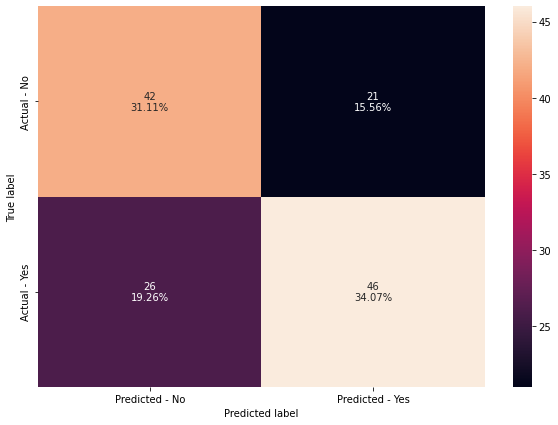

In [16]:
Everything_Everywhere_All_At_Once(decisiontree,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Bagging Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9876543209876543
Accuracy on test set :  0.7777777777777778
Recall on training set :  0.9814814814814815
Recall on test set :  0.8055555555555556
Precision on training set :  0.9953051643192489
Precision on test set :  0.7837837837837838
--------------------------------------------------


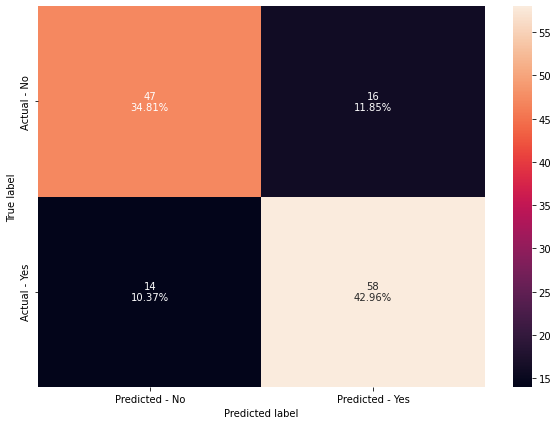

In [17]:
Everything_Everywhere_All_At_Once(bagging,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Logistic Regression Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.837037037037037
Accuracy on test set :  0.7925925925925926
Recall on training set :  0.8518518518518519
Recall on test set :  0.8333333333333334
Precision on training set :  0.8440366972477065
Precision on test set :  0.7894736842105263
--------------------------------------------------


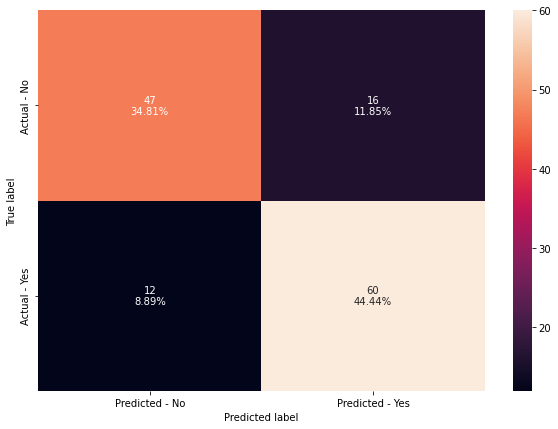

In [18]:
Everything_Everywhere_All_At_Once(logitreg,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Random Forest Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.8148148148148148
Recall on training set :  1.0
Recall on test set :  0.8472222222222222
Precision on training set :  1.0
Precision on test set :  0.8133333333333334
--------------------------------------------------


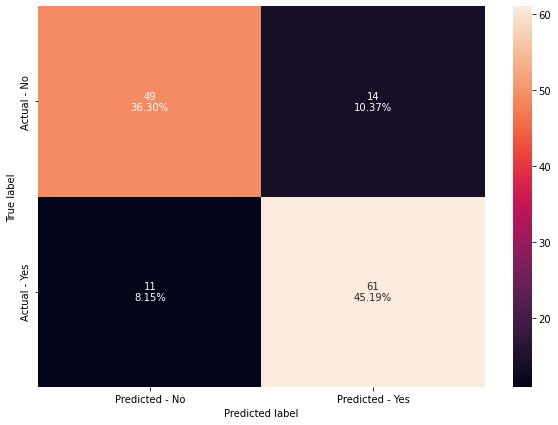

In [19]:
Everything_Everywhere_All_At_Once(randiforestclass,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the AdaBoost Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.8962962962962963
Accuracy on test set :  0.762962962962963
Recall on training set :  0.8888888888888888
Recall on test set :  0.8055555555555556
Precision on training set :  0.9142857142857143
Precision on test set :  0.7631578947368421
--------------------------------------------------


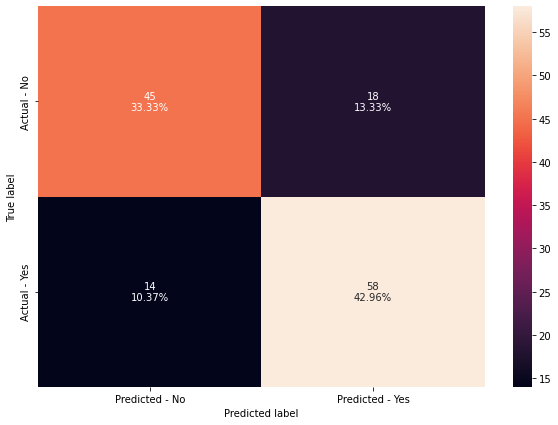

In [20]:
Everything_Everywhere_All_At_Once(adaboost,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9703703703703703
Accuracy on test set :  0.762962962962963
Recall on training set :  0.9722222222222222
Recall on test set :  0.7638888888888888
Precision on training set :  0.9722222222222222
Precision on test set :  0.7857142857142857
--------------------------------------------------


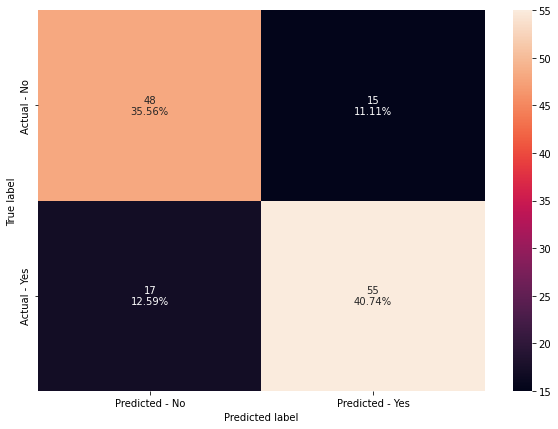

In [21]:
Everything_Everywhere_All_At_Once(gradientboost,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Extreme Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.7481481481481481
Recall on training set :  1.0
Recall on test set :  0.7638888888888888
Precision on training set :  1.0
Precision on test set :  0.7638888888888888
--------------------------------------------------


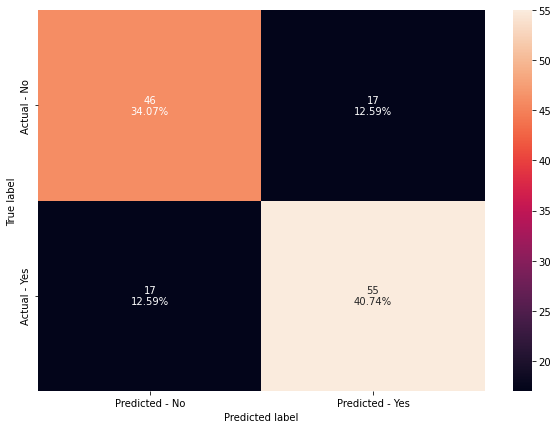

In [22]:
Everything_Everywhere_All_At_Once(xgboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [23]:
model_names = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
for model_class in class_list:
    model_names.append(model_class.name)
    acc_train.append(model_class.scores[0])
    acc_test.append(model_class.scores[1])
    recall_train.append(model_class.scores[2])
    recall_test.append(model_class.scores[3])
    precision_train.append(model_class.scores[4])
    precision_test.append(model_class.scores[5])

In [24]:
comparison_frame = pd.DataFrame(
    {
        "Model": model_names,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)
#comparison_frame.sort_values(by='Test_Accuracy')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Classifier,1.000,0.652,1.000,0.639,1.000,0.687
1,Bagging Classifier,0.988,0.778,0.981,0.806,0.995,0.784
2,Logistic Regression Classifier,0.837,0.793,0.852,0.833,0.844,0.789
3,Random Forest Classifier,1.000,0.815,1.000,0.847,1.000,0.813
4,AdaBoost Classifier,0.896,0.763,0.889,0.806,0.914,0.763
5,Gradient Boosting Classifier,0.970,0.763,0.972,0.764,0.972,0.786
6,Extreme Gradient Boosting Classifier,1.000,0.748,1.000,0.764,1.000,0.764


In [25]:
comparison_frame.sort_values(by=['Test_Accuracy'], inplace=True, ascending=False)
comparison_frame.reset_index(inplace=True,drop=True)
#comparison_frame.drop('index')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Random Forest Classifier,1.000,0.815,1.000,0.847,1.000,0.813
1,Logistic Regression Classifier,0.837,0.793,0.852,0.833,0.844,0.789
2,Bagging Classifier,0.988,0.778,0.981,0.806,0.995,0.784
3,AdaBoost Classifier,0.896,0.763,0.889,0.806,0.914,0.763
4,Gradient Boosting Classifier,0.970,0.763,0.972,0.764,0.972,0.786
5,Extreme Gradient Boosting Classifier,1.000,0.748,1.000,0.764,1.000,0.764
6,Decision Tree Classifier,1.000,0.652,1.000,0.639,1.000,0.687


### Hyperparameter Tuning
#### To my teammates:
Gridsearch is a tool used to bruteforce search a matrix of hyperparameters for a model. The model will be optimized to the training set so overfitting is a risk. However, in my experience a tuned model is very powerful so we'll see how effective this is.

In [26]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {'decisiontreeclassifier__max_depth': np.arange(2,30), 
#               'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
#               'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10,15],
#               'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
#              }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Decision Tree Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.8888888888888888
Accuracy on test set :  0.6962962962962963
Recall on training set :  0.8935185185185185
Recall on test set :  0.7222222222222222
Precision on training set :  0.8976744186046511
Precision on test set :  0.7123287671232876
--------------------------------------------------


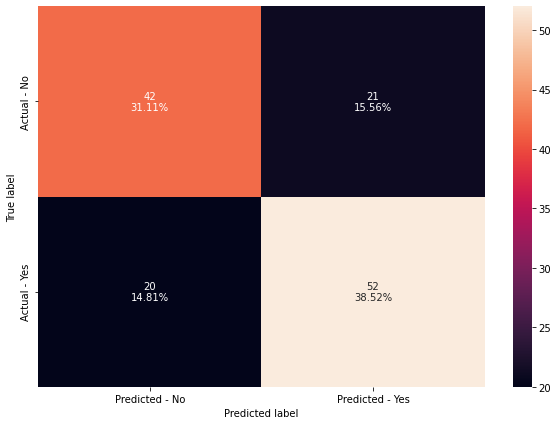

In [27]:
class tuned_decision_tree:
    name = "Tuned Decision Tree Classifier"
tuned_decision_tree.model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=6,
        max_leaf_nodes=15,
        random_state=1,
        min_impurity_decrease=0.0001,
        min_samples_leaf=1
    ),
)
class_list.append(tuned_decision_tree)
Everything_Everywhere_All_At_Once(tuned_decision_tree,X_train_scaled,y_train,X_test_scaled,y_test)

In [28]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {
#               'baggingclassifier__max_samples': [0.7,0.8,0.9,1], 
#               'baggingclassifier__max_features': [0.7,0.8,0.9,1],
#               'baggingclassifier__n_estimators' : [10,20,30,40,50],
#              }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Bagging Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9851851851851852
Accuracy on test set :  0.8148148148148148
Recall on training set :  0.9861111111111112
Recall on test set :  0.8611111111111112
Precision on training set :  0.9861111111111112
Precision on test set :  0.8051948051948052
--------------------------------------------------


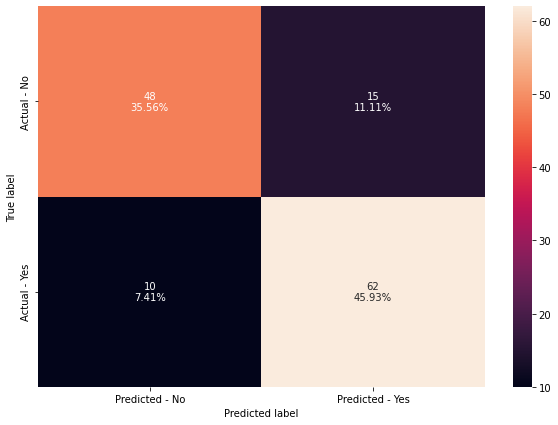

In [29]:
class tuned_bagging:
    name = "Tuned Bagging Classifier"
tuned_bagging.model = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.8,
        max_samples=0.7,
        random_state=1,
        n_estimators=30,
    ),
)
class_list.append(tuned_bagging)
Everything_Everywhere_All_At_Once(tuned_bagging,X_train_scaled,y_train,X_test_scaled,y_test)

In [30]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {
#     "randomforestclassifier__n_estimators": [100,150,250],
#     "randomforestclassifier__min_samples_leaf": np.arange(1, 6),
#     "randomforestclassifier__max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
#     "randomforestclassifier__max_samples": np.arange(0.2, 0.6, 0.1),
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Random Forest Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9012345679012346
Accuracy on test set :  0.8074074074074075
Recall on training set :  0.9120370370370371
Recall on test set :  0.8472222222222222
Precision on training set :  0.9036697247706422
Precision on test set :  0.8026315789473685
--------------------------------------------------


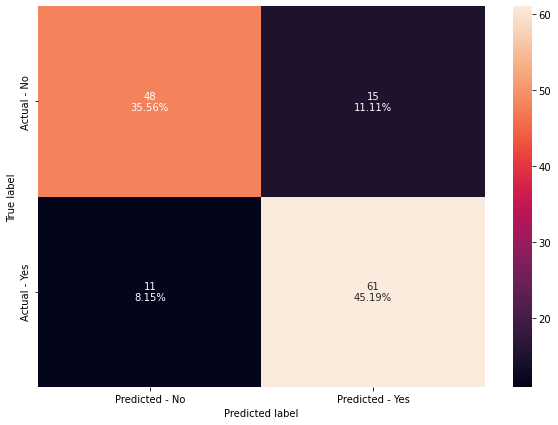

In [31]:
class tuned_randiforestclass:
    name = "Tuned Random Forest Classifier"
tuned_randiforestclass.model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=250,
        max_features='sqrt',
        random_state=1,
        max_samples=0.3,
        min_samples_leaf=2
    ),
)
class_list.append(tuned_randiforestclass)
Everything_Everywhere_All_At_Once(tuned_randiforestclass,X_train_scaled,y_train,X_test_scaled,y_test)

In [32]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV
# param_grid = {
#     "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
#     "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
#     "adaboostclassifier__base_estimator": [
#         DecisionTreeClassifier(max_depth=1, random_state=1),
#         DecisionTreeClassifier(max_depth=2, random_state=1),
#         DecisionTreeClassifier(max_depth=3, random_state=1),
#     ],
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned AdaBoost Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9333333333333333
Accuracy on test set :  0.7481481481481481
Recall on training set :  0.9120370370370371
Recall on test set :  0.7638888888888888
Precision on training set :  0.9609756097560975
Precision on test set :  0.7638888888888888
--------------------------------------------------


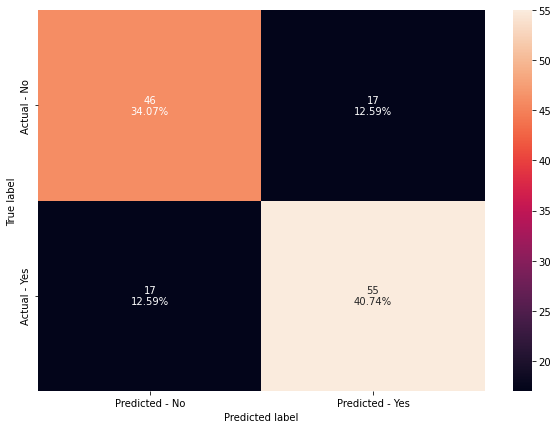

In [33]:
class tuned_adaboost:
    name = "Tuned AdaBoost Classifier"
tuned_adaboost.model = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
        n_estimators=60,
        learning_rate=0.1,
        random_state=1,
    ),
)
class_list.append(tuned_adaboost)
Everything_Everywhere_All_At_Once(tuned_adaboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [34]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV
# param_grid = {
#     "gradientboostingclassifier__init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
#     "gradientboostingclassifier__n_estimators": np.arange(75,150,25),
#     "gradientboostingclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
#     "gradientboostingclassifier__subsample":[0.5,0.7,1],
#     "gradientboostingclassifier__max_features":[0.5,0.7,1],
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.891358024691358
Accuracy on test set :  0.7925925925925926
Recall on training set :  0.9074074074074074
Recall on test set :  0.8333333333333334
Precision on training set :  0.8909090909090909
Precision on test set :  0.7894736842105263
--------------------------------------------------


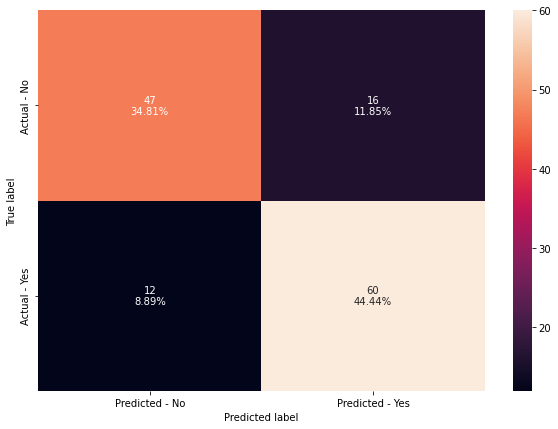

In [35]:
class tuned_gradientboost:
    name = "Tuned Gradient Boosting Classifier"
tuned_gradientboost.model = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        init=AdaBoostClassifier(random_state=1),
        learning_rate=0.01,
        max_features=0.5,
        n_estimators=100,
        subsample=0.5,
        random_state=1,
    ),
)
class_list.append(tuned_gradientboost)
Everything_Everywhere_All_At_Once(tuned_gradientboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [36]:
# #Creating pipeline
# pipe=make_pipeline(StandardScaler(), XGBClassifier(random_state=1,eval_metric='logloss'))

# #Parameter grid to pass in GridSearchCV
# param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
#             'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 'xgbclassifier__gamma':[0,1,3,5],
#             'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Extreme Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.928395061728395
Accuracy on test set :  0.7777777777777778
Recall on training set :  0.9351851851851852
Recall on test set :  0.8055555555555556
Precision on training set :  0.9308755760368663
Precision on test set :  0.7837837837837838
--------------------------------------------------


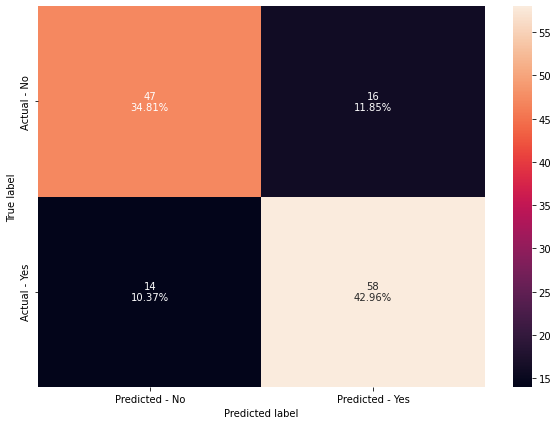

In [37]:
class tuned_xgboost:
    name = "Tuned Extreme Gradient Boosting Classifier"
tuned_xgboost.model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=100,
        scale_pos_weight=1,
        subsample=0.7,
        learning_rate=0.01,
        gamma=0,
        eval_metric='logloss',
    ),
)
class_list.append(tuned_xgboost)
Everything_Everywhere_All_At_Once(tuned_xgboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [38]:
model_names = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
for model_class in class_list:
    model_names.append(model_class.name)
    acc_train.append(model_class.scores[0])
    acc_test.append(model_class.scores[1])
    recall_train.append(model_class.scores[2])
    recall_test.append(model_class.scores[3])
    precision_train.append(model_class.scores[4])
    precision_test.append(model_class.scores[5])

In [39]:
comparison_frame = pd.DataFrame(
    {
        "Model": model_names,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)
comparison_frame.sort_values(by='Test_Accuracy')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Classifier,1.000,0.652,1.000,0.639,1.000,0.687
1,Bagging Classifier,0.988,0.778,0.981,0.806,0.995,0.784
2,Logistic Regression Classifier,0.837,0.793,0.852,0.833,0.844,0.789
3,Random Forest Classifier,1.000,0.815,1.000,0.847,1.000,0.813
4,AdaBoost Classifier,0.896,0.763,0.889,0.806,0.914,0.763
5,Gradient Boosting Classifier,0.970,0.763,0.972,0.764,0.972,0.786
6,Extreme Gradient Boosting Classifier,1.000,0.748,1.000,0.764,1.000,0.764
7,Tuned Decision Tree Classifier,0.889,0.696,0.894,0.722,0.898,0.712
8,Tuned Bagging Classifier,0.985,0.815,0.986,0.861,0.986,0.805
9,Tuned Random Forest Classifier,0.901,0.807,0.912,0.847,0.904,0.803


In [40]:
comparison_frame.sort_values(by=['Test_Accuracy'], inplace=True, ascending=False)
comparison_frame.reset_index(inplace=True,drop=True)
#comparison_frame.drop('index')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Random Forest Classifier,1.000,0.815,1.000,0.847,1.000,0.813
1,Tuned Bagging Classifier,0.985,0.815,0.986,0.861,0.986,0.805
2,Tuned Random Forest Classifier,0.901,0.807,0.912,0.847,0.904,0.803
3,Logistic Regression Classifier,0.837,0.793,0.852,0.833,0.844,0.789
4,Tuned Gradient Boosting Classifier,0.891,0.793,0.907,0.833,0.891,0.789
5,Bagging Classifier,0.988,0.778,0.981,0.806,0.995,0.784
6,Tuned Extreme Gradient Boosting Classifier,0.928,0.778,0.935,0.806,0.931,0.784
7,AdaBoost Classifier,0.896,0.763,0.889,0.806,0.914,0.763
8,Gradient Boosting Classifier,0.970,0.763,0.972,0.764,0.972,0.786
9,Extreme Gradient Boosting Classifier,1.000,0.748,1.000,0.764,1.000,0.764


In [41]:
top_name = comparison_frame['Model'][0]
second_best = comparison_frame['Model'][1]
third_best = comparison_frame['Model'][2]
print(f"Best model is the {top_name} model\n"
     f"Second best model is the {second_best} model\n"
     f"Third best model is the {third_best} model")

Best model is the Random Forest Classifier model
Second best model is the Tuned Bagging Classifier model
Third best model is the Tuned Random Forest Classifier model


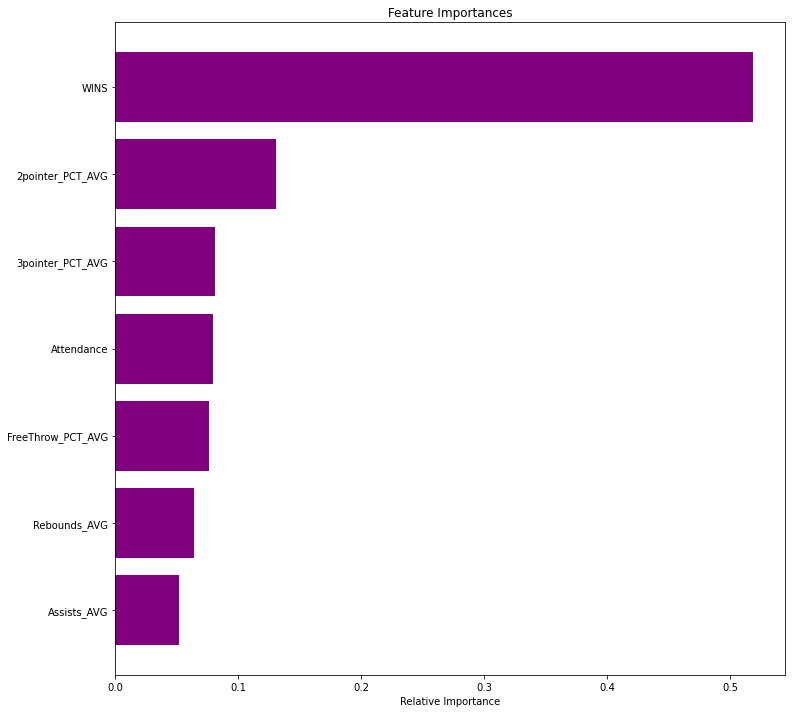

In [42]:
#example of feature importance.
feature_names = X_train.columns
importances = tuned_xgboost.model[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="purple", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [43]:
top_name = comparison_frame['Model'][0]
second_best = comparison_frame['Model'][1]
third_best = comparison_frame['Model'][2]
print(f"Best model is the {top_name} model\n"
     f"Second best model is the {second_best} model\n"
     f"Third best model is the {third_best} model")


Best model is the Random Forest Classifier model
Second best model is the Tuned Bagging Classifier model
Third best model is the Tuned Random Forest Classifier model


In [46]:
# export the model
import pickle
for model_class in class_list:
    if model_class.name == top_name:
        filename = '../Models/top_model.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))
    elif model_class.name == second_best:
        filename = '../Models/second_best.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))
    elif model_class.name == third_best:
        filename = '../Models/third_best.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))

In [ ]:
#left over because idk